In [100]:
import os
import random
import pandas as pd
import numpy as np
from glob import glob
import cv2
from collections import defaultdict
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch.nn as nn
from torchvision import models
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.nn.functional as F

# Datasets used

#### */kaggle/input/gtsrb-resized-test-data*
#### */kaggle/input/gtsrb-test-attacked*
#### */kaggle/input/final-trained-models-resized-gtsrb-dataset*
#### */kaggle/input/attacked-dataset-with-a-different-intensity*
#### */kaggle/input/least-intense-attack-gtsrb*

In [101]:
intensity = int(input("Select the intensity of the attack (select the number):\n 1. Least intensity\n 2. Intermediate Intensity\n 3. High Intensity\n"))

Select the intensity of the attack (select the number):
 1. Least intensity
 2. Intermediate Intensity
 3. High Intensity
 1


In [102]:
original_test_dir = "/kaggle/input/gtsrb-resized-test-data"

attacked_test_dir = " "

if intensity == 1:
    attacked_test_dir = "/kaggle/input/gtsrb-resized-test-advattack-less-intense/gtsrb_resized_test_advAttackedlessintense++"
elif intensity == 2:
    attacked_test_dir = "/kaggle/input/attacked-dataset-with-a-different-intensity/gtsrb_resized_test_advAttacked+++"
elif intensity == 3:
    attacked_test_dir = "/kaggle/input/gtsrb-test-attacked/gtsrb_resized_test_advAttacked+++++"


# Collect all attacked images and their relative paths (example: 35/00085.png)
attacked_image_paths = glob(os.path.join(attacked_test_dir, "*", "*.png"))
attacked_relative_paths = [os.path.relpath(path, attacked_test_dir) for path in attacked_image_paths]

# Now we find the corresponding original test image paths
original_image_paths = [os.path.join(original_test_dir, rel_path) for rel_path in attacked_relative_paths]

# Example
print("Sample attacked image path:", attacked_image_paths[0])
print("Corresponding original image path:", original_image_paths[0])
print(f"Total matched images: {len(original_image_paths)}")

Sample attacked image path: /kaggle/input/gtsrb-resized-test-advattack-less-intense/gtsrb_resized_test_advAttackedlessintense++/7/02630.png
Corresponding original image path: /kaggle/input/gtsrb-resized-test-data/7/02630.png
Total matched images: 1600


In [103]:
TRAIN_CSV = '/kaggle/input/gtsrb-csv-data/Train.csv'
df = pd.read_csv(TRAIN_CSV)

# Get the most frequent classes (we are choosing the top 16 classes)
TARGET_CLASSES = 16 
class_counts = df['ClassId'].value_counts()

# Get the top classes and sort them for consistency (we did this previously too while training the model)
top_classes = sorted(class_counts[:TARGET_CLASSES].index.tolist())

# Create label remapping (original labels to new indices)
class_id_to_index = {orig: idx for idx, orig in enumerate(top_classes)}
index_to_class_id = {v: k for k, v in class_id_to_index.items()}

# Printing the label mapping
print("Label Mapping:")
for k, v in class_id_to_index.items():
    print(f"Original label {k} → New index {v}")


Label Mapping:
Original label 1 → New index 0
Original label 2 → New index 1
Original label 3 → New index 2
Original label 4 → New index 3
Original label 5 → New index 4
Original label 7 → New index 5
Original label 8 → New index 6
Original label 9 → New index 7
Original label 10 → New index 8
Original label 11 → New index 9
Original label 12 → New index 10
Original label 13 → New index 11
Original label 18 → New index 12
Original label 25 → New index 13
Original label 35 → New index 14
Original label 38 → New index 15


In [104]:
# Loading the original and attacked image as well as their labels to use for evaluating/testing
class GTSRBPairDataset(Dataset):
    def __init__(self, original_image_paths, attacked_image_paths, transform=None):
        self.original_image_paths = original_image_paths
        self.attacked_image_paths = attacked_image_paths
        self.transform = transform

    def __len__(self):
        return len(self.original_image_paths)

    def __getitem__(self, idx):
        # Loading original and attacked image
        orig_path = self.original_image_paths[idx]
        adv_path = self.attacked_image_paths[idx]

        orig_img = cv2.imread(orig_path)
        adv_img = cv2.imread(adv_path)

        # Converting BGR to RGB
        orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
        adv_img = cv2.cvtColor(adv_img, cv2.COLOR_BGR2RGB)

        # Getting the label from the folder name (it is the label itself)
        label = int(orig_path.split('/')[-2])  

        if self.transform:
            orig_img = self.transform(orig_img)
            adv_img = self.transform(adv_img)

        return orig_img, adv_img, label, orig_path.split("/")[-2] + "/" + orig_path.split("/")[-1]

# Defining transforms (matching training config)
resize_dims = (224, 224)
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(resize_dims),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Initialising dataset
dataset = GTSRBPairDataset(original_image_paths, attacked_image_paths, transform=transform)

orig_img, adv_img, label, img_name = dataset[0]
print(f"Label: {label}, Image name: {img_name}")
print(f"Original image shape: {orig_img.shape}, Attacked image shape: {adv_img.shape}")


Label: 7, Image name: 7/02630.png
Original image shape: torch.Size([3, 224, 224]), Attacked image shape: torch.Size([3, 224, 224])


In [105]:
modelidx = int(input("Select the model you want to use for testing:\n 1. ResNet50\n 2. DenseNet121\n 3. MobileNetV2\n"))

Select the model you want to use for testing:
 1. ResNet50
 2. DenseNet121
 3. MobileNetV2
 1


In [106]:
# Loading the models on the basis of what model we want to test (resnet50, densenet121, mobilenetv2)

def load_model(pth_path):
    if modelidx == 1:
        model = models.resnet50(weights=None)
        model.fc = nn.Linear(model.fc.in_features, 16) 
    
    elif modelidx == 3:
        model = models.mobilenet_v2(weights=None)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, 16)

    else:
        model = models.densenet121(weights=None)
        model.classifier = nn.Linear(model.classifier.in_features, 16)
    
    model.load_state_dict(torch.load(pth_path, map_location='cpu'))
    model.eval()
    return model

# Path to model .pth file (changing it according to the model we are testing)

if modelidx == 1:
    model_path = "/kaggle/input/final-trained-models-resized-gtsrb-dataset/resnet50_gtsrb_top16.pth"

elif modelidx == 2:
    model_path = "/kaggle/input/final-trained-models-resized-gtsrb-dataset/densenet121_gtsrb_top16.pth"

else:
    model_path = "/kaggle/input/final-trained-models-resized-gtsrb-dataset/mobilenet_v2_gtsrb_top16.pth"
    
model = load_model(model_path)

# Using the GPU on Kaggle (GPU T4 x2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

/tmp/ipykernel_31/3872255000.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(pth_path, map_location='cpu'))


In [107]:
def visualize_random_attacks_from_class(label_class,
                                         original_test_dir,
                                         attacked_test_dir,
                                         model,
                                         transform,
                                         class_id_to_index,
                                         index_to_class_id,
                                         device=torch.device("cpu"),
                                         num_samples=5):

    class_attack_dir = os.path.join(attacked_test_dir, label_class)
    all_files = os.listdir(class_attack_dir)
    image_files = [f for f in all_files if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    if len(image_files) == 0:
        print(f"No images found in class folder {label_class}")
        return
    
    chosen_files = random.sample(image_files, min(num_samples, len(image_files)))

    def predict(img):
        x = transform(img).unsqueeze(0).to(device)
        with torch.no_grad():
            out = model(x)
            probs = F.softmax(out, dim=1)
            conf, pred = probs.max(dim=1)
        return pred.item(), conf.item()
    
    plt.figure(figsize=(10, 5 * len(chosen_files)))
    for i, filename in enumerate(chosen_files):
        adv_path = os.path.join(class_attack_dir, filename)
        orig_path = os.path.join(original_test_dir, label_class, filename)
        
        # Read and convert
        orig_bgr = cv2.imread(orig_path)
        adv_bgr = cv2.imread(adv_path)
        orig_rgb = cv2.cvtColor(orig_bgr, cv2.COLOR_BGR2RGB)

        orig_pred_idx, orig_conf = predict(orig_bgr)
        adv_pred_idx, adv_conf = predict(adv_bgr)

        orig_pred_class = index_to_class_id[orig_pred_idx]
        adv_pred_class = index_to_class_id[adv_pred_idx]

        # Plot
        plt.subplot(len(chosen_files), 2, 2 * i + 1)
        plt.imshow(orig_rgb)
        plt.axis('off')
        plt.title(f"Original\nTrue: {label_class}\nPred: {orig_pred_class} ({orig_conf:.2f})")

        plt.subplot(len(chosen_files), 2, 2 * i + 2)
        plt.imshow(adv_bgr)
        plt.axis('off')
        plt.title(f"Attacked\nTrue: {label_class}\nPred: {adv_pred_class} ({adv_conf:.2f})")
    
    plt.tight_layout()
    plt.show()


Evaluating: 100%|██████████| 50/50 [01:22<00:00,  1.65s/batch]


Complete Test Dataset Evaluation:
Original Accuracy: 97.38%
Attacked Accuracy: 57.75%
Average Original Confidence: 0.9841
Average Attacked Confidence: 0.8845


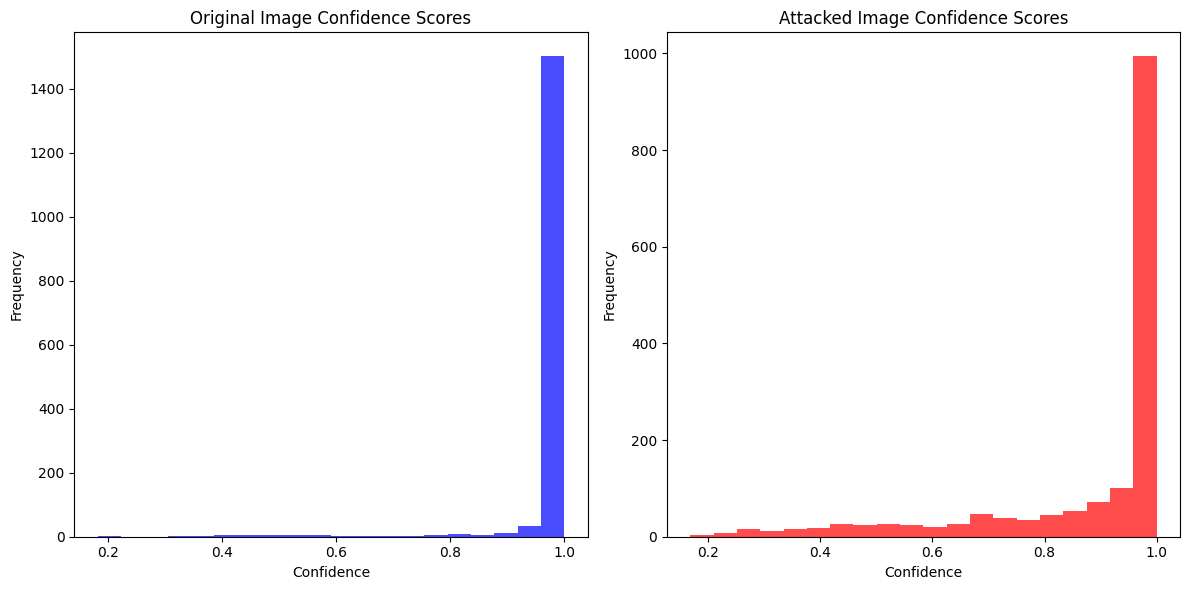

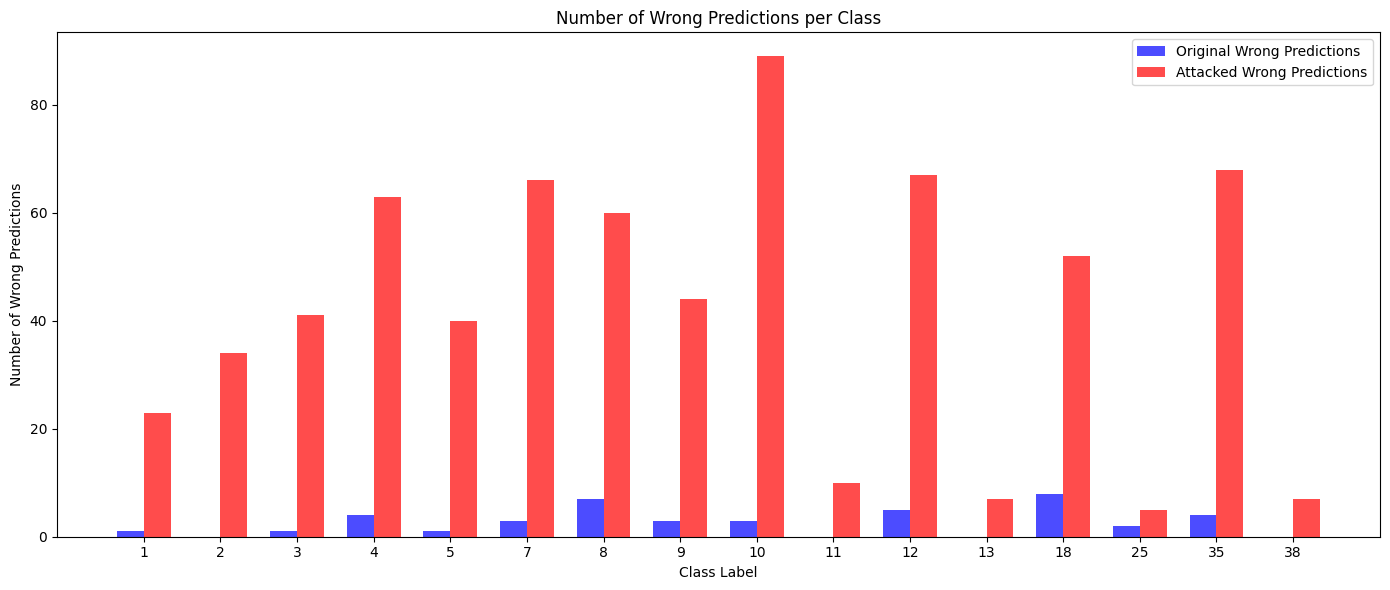

Total wrong predictions (original): 42
Total wrong predictions (attacked): 676
Class with most errors under attack: 10 with 89 errors


In [108]:
def evaluate_complete_dataset(model, dataset, device, index_to_class_id):
    
    model.eval()
    loader = DataLoader(dataset, batch_size=32, shuffle=False)
    
    original_confidences = []
    attacked_confidences = []
    original_correct = 0
    attacked_correct = 0
    total_samples = 0
    
    # Lists to store all true labels and predictions of the images (attacked as well as original image)
    true_labels_list = []
    mapped_orig_preds_list = []
    mapped_adv_preds_list = []

    with torch.no_grad():
        for orig_imgs, adv_imgs, labels, _ in tqdm(loader, desc="Evaluating", unit="batch"):
            orig_imgs = orig_imgs.to(device)
            adv_imgs = adv_imgs.to(device)
            labels = labels.to(device)

            # Forward pass for the original and attacked images.
            orig_outputs = model(orig_imgs)
            adv_outputs = model(adv_imgs)

            # Get softmax probabilities.
            orig_probs = F.softmax(orig_outputs, dim=1)
            adv_probs = F.softmax(adv_outputs, dim=1)
            
            # Getting the confidence scores and predicted new class indices.
            orig_conf_batch, orig_preds = orig_probs.max(dim=1)
            adv_conf_batch, adv_preds = adv_probs.max(dim=1)
            
            # Storing batch confidence values (to store )
            original_confidences.extend(orig_conf_batch.cpu().tolist())
            attacked_confidences.extend(adv_conf_batch.cpu().tolist())
            
            # Map predictions from new (0-15) to the original labels.
            mapped_orig_preds = [index_to_class_id[p.item()] for p in orig_preds]
            mapped_adv_preds = [index_to_class_id[p.item()] for p in adv_preds]
            
            # Storing all labels and predictions
            true_labels_list.extend(labels.cpu().tolist())
            mapped_orig_preds_list.extend(mapped_orig_preds)
            mapped_adv_preds_list.extend(mapped_adv_preds)
            
            # The dataset returns the original label directly, so compare accordingly.
            labels_list = labels.cpu().tolist()
            batch_size = len(labels_list)
            for i in range(batch_size):
                if mapped_orig_preds[i] == labels_list[i]:
                    original_correct += 1
                if mapped_adv_preds[i] == labels_list[i]:
                    attacked_correct += 1
            
            total_samples += batch_size

    original_accuracy = original_correct / total_samples
    attacked_accuracy = attacked_correct / total_samples
    
    return original_accuracy, attacked_accuracy, original_confidences, attacked_confidences, true_labels_list, mapped_orig_preds_list, mapped_adv_preds_list

# Evaluate the model on the complete test dataset
orig_acc, adv_acc, orig_conf, adv_conf, true_labels, orig_preds, adv_preds = evaluate_complete_dataset(model, dataset, device, index_to_class_id)

# Print the computed accuracies and average confidence values.
print("Complete Test Dataset Evaluation:")
print(f"Original Accuracy: {orig_acc * 100:.2f}%")
print(f"Attacked Accuracy: {adv_acc * 100:.2f}%")
print(f"Average Original Confidence: {np.mean(orig_conf):.4f}")
print(f"Average Attacked Confidence: {np.mean(adv_conf):.4f}")

# Plot histograms for the confidence scores.
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(orig_conf, bins=20, color='blue', alpha=0.7)
plt.title("Original Image Confidence Scores")
plt.xlabel("Confidence")
plt.ylabel("Frequency")

plt.subplot(1, 2, 2)
plt.hist(adv_conf, bins=20, color='red', alpha=0.7)
plt.title("Attacked Image Confidence Scores")
plt.xlabel("Confidence")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


def plot_wrong_predictions_per_class(true_labels, orig_preds, adv_preds):

    #Plots a grouped bar chart showing the number of wrong predictions per class for both original and attacked images.
    
    # Count wrong predictions per class
    wrong_original_counts = defaultdict(int)
    wrong_attacked_counts = defaultdict(int)
    
    # Getting unique class labels in the dataset
    unique_labels = sorted(set(true_labels))
    
    for true_label, orig_pred, adv_pred in zip(true_labels, orig_preds, adv_preds):
        if orig_pred != true_label:
            wrong_original_counts[true_label] += 1
        if adv_pred != true_label:
            wrong_attacked_counts[true_label] += 1
    
    # Converting to lists for plotting
    classes = unique_labels
    wrong_original_list = [wrong_original_counts.get(c, 0) for c in classes]
    wrong_attacked_list = [wrong_attacked_counts.get(c, 0) for c in classes]
    
    plt.figure(figsize=(14, 6))
    bar_width = 0.35
    indices = range(len(classes))
    
    plt.bar(indices, wrong_original_list, bar_width, label='Original Wrong Predictions', color='blue', alpha=0.7)
    plt.bar([i + bar_width for i in indices], wrong_attacked_list, bar_width, label='Attacked Wrong Predictions', color='red', alpha=0.7)
    
    plt.xlabel('Class Label')
    plt.ylabel('Number of Wrong Predictions')
    plt.title('Number of Wrong Predictions per Class')
    plt.xticks([i + bar_width / 2 for i in indices], classes)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    total_wrong_original = sum(wrong_original_list)
    total_wrong_attacked = sum(wrong_attacked_list)
    print(f"Total wrong predictions (original): {total_wrong_original}")
    print(f"Total wrong predictions (attacked): {total_wrong_attacked}")
    
    if wrong_attacked_list:
        most_error_idx = wrong_attacked_list.index(max(wrong_attacked_list))
        print(f"Class with most errors under attack: {classes[most_error_idx]} with {wrong_attacked_list[most_error_idx]} errors")

plot_wrong_predictions_per_class(true_labels, orig_preds, adv_preds)


/tmp/ipykernel_31/3872255000.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(pth_path, map_location='cpu'))


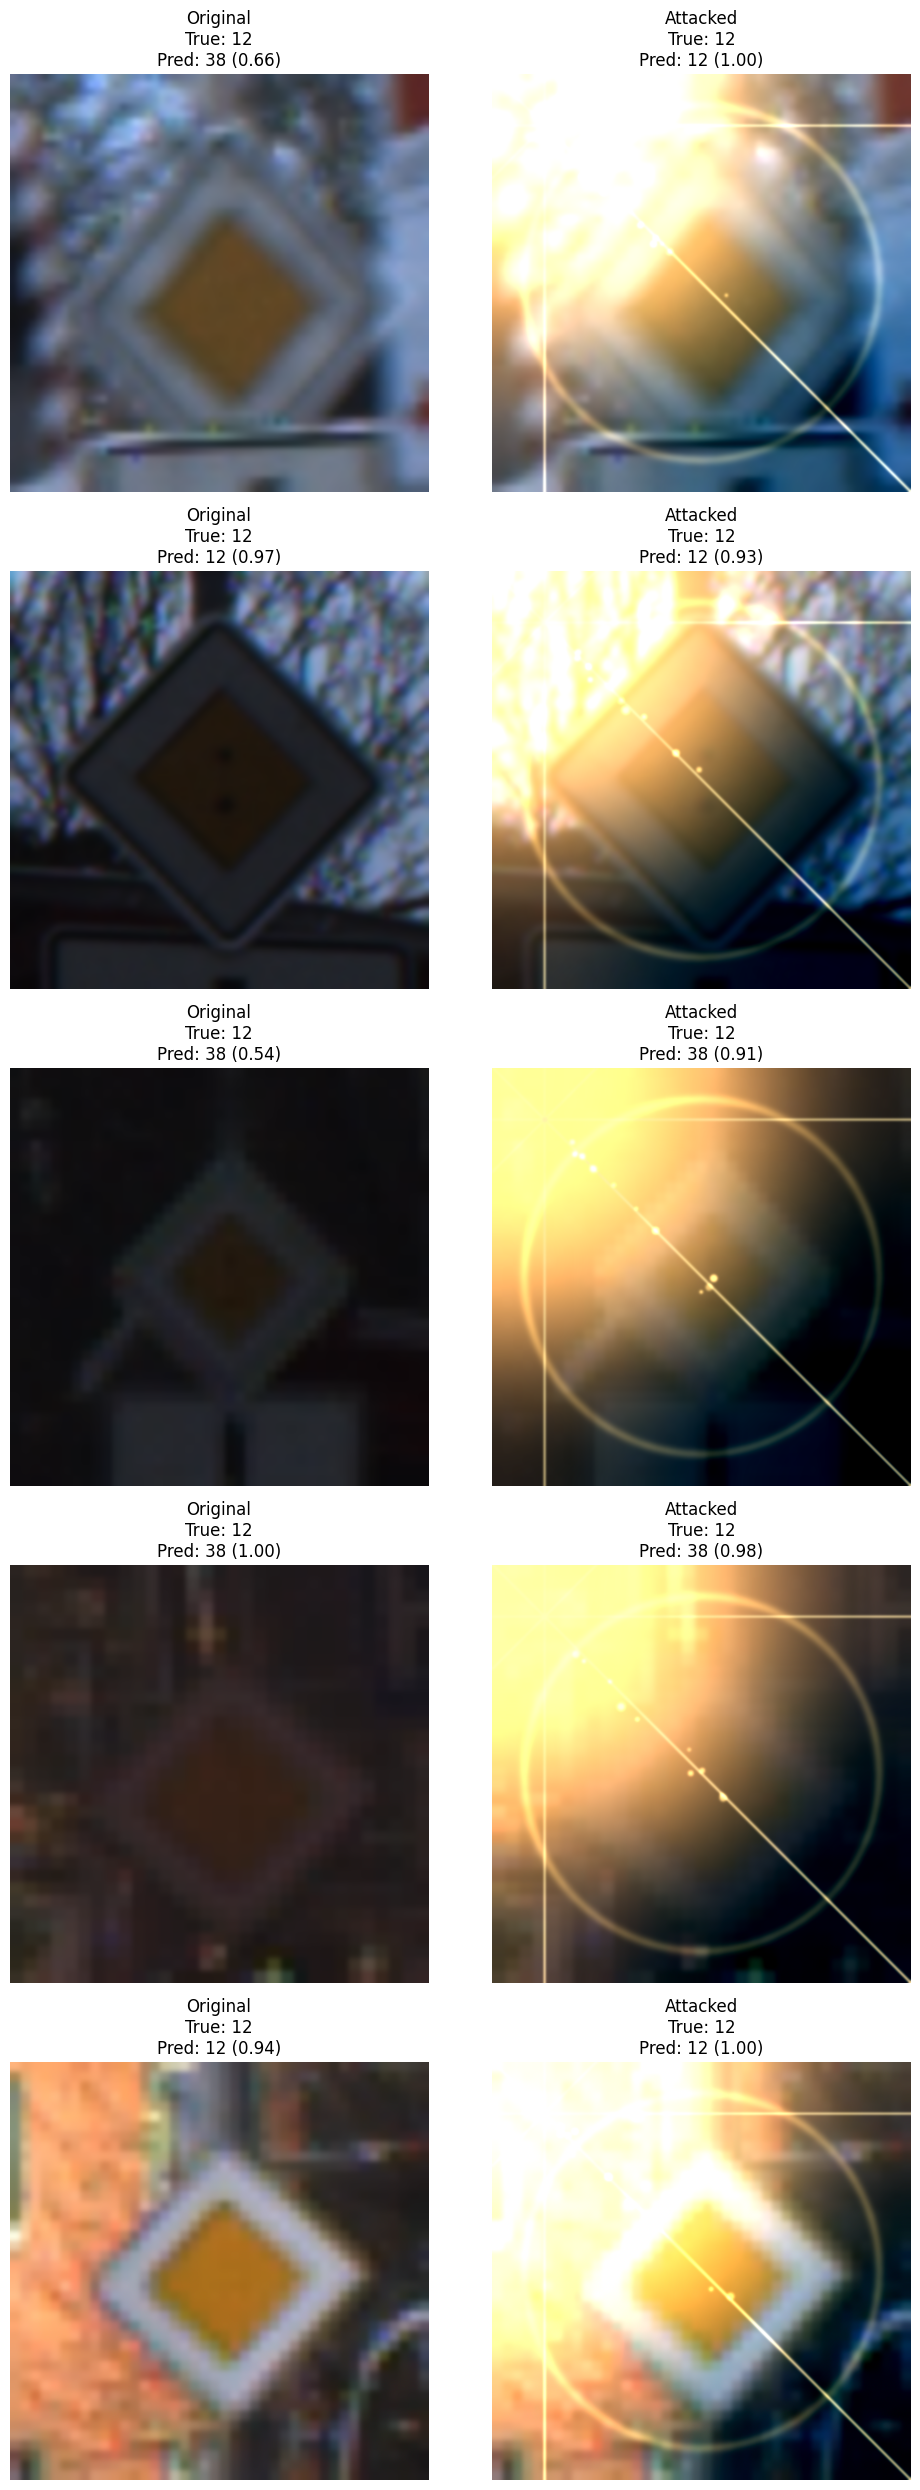

In [129]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = load_model(model_path).to(device)

visualize_random_attacks_from_class(
    label_class="12",  # We can select the class we want to see particularly
    original_test_dir=original_test_dir,
    attacked_test_dir=attacked_test_dir,
    model=model,
    transform=transform,
    class_id_to_index=class_id_to_index,
    index_to_class_id=index_to_class_id,
    device=device,
    num_samples=5
)